- [VAE combined with VAE](https://www.tvhahn.com/posts/building-vae/)

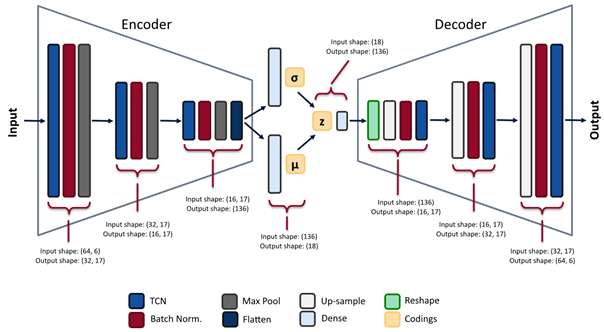

In [55]:
from TCN import TemporalConvNet, TemporalBlock
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal

In [49]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1) # (in_channels, out_channels, kernel_size)
        self.batchnorm = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=0) 
        self.batchnorm2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=0)
        self.linear1 = nn.Linear(32*6*6, 128)
        self.linear2 = nn.Linear(128, latent_dim) # for mean 
        self.linear3 = nn.Linear(128, latent_dim) # for variance
    
    def compute_flatten_input_shape(self, x):
        print(x.shape)
        self.linear_tmp = nn.Linear(x.view(x.size[0]), 128)
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.batchnorm(x))
        x = self.conv2(x)
        x = F.relu(self.batchnorm2(x))
        x = F.relu(self.conv3(x))
        # print('final convolution: ', x.shape)
        x = torch.flatten(x, start_dim=1) 
        # compute_flatten_input_shape(x)
        print(x.shape)
        # print('after flatten: ', x.shape)
        x = F.relu(self.linear1(x))
        # print(x.shape)
        mu = self.linear2(x)
        # print(mu.shape)
        log_var = self.linear3(x)
        # print(mu)
        return mu, log_var

In [50]:
from torchsummary import summary
CUDA = torch.cuda.is_available()
# torch.cuda.set_device(1) # set pytorch run
device = torch.device('cuda' if CUDA else 'cpu')

input_size = (1, 28, 28)
encoder = Encoder(10)
summary(encoder.to(device), input_size, batch_size=1) #, device='cuda'

torch.Size([2, 1152])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [1, 8, 28, 28]              80
       BatchNorm2d-2             [1, 8, 28, 28]              16
            Conv2d-3            [1, 16, 13, 13]           1,168
       BatchNorm2d-4            [1, 16, 13, 13]              32
            Conv2d-5              [1, 32, 6, 6]           4,640
            Linear-6                   [1, 128]         147,584
            Linear-7                    [1, 10]           1,290
            Linear-8                    [1, 10]           1,290
Total params: 156,100
Trainable params: 156,100
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.15
Params size (MB): 0.60
Estimated Total Size (MB): 0.75
----------------------------------------------------------------


In [17]:
encoder = Encoder(10)

In [18]:
encoder.children()

<generator object Module.children at 0x000001A06753AC80>

In [19]:
encoder.modules()

<generator object Module.modules at 0x000001A06753A9E0>

In [22]:
# get the shape of input or output layers
print('linear 1 (dimension of output output feature): ', encoder.linear1.in_features)
print('linear 3 (dimension of output output feature): ', encoder.linear3.in_features)
print('linear 3 (dimension of output output feature): ', encoder.linear3.out_features)

linear 1 (dimension of output output feature):  1152
linear 3 (dimension of output output feature):  128
linear 3 (dimension of output output feature):  10


### Compairson
- ```model.modules()```: 所有layer & model (```nn.Module``` layer) 
- ```model.named_modules()```: 有名字的```model.modules()```: 同時也返回layer的名字
- ```model.children()```: 所有model 內部的layer

In [38]:
model_modules = [x for x in encoder.modules()]
model_named_modules  = [x for x in encoder.named_modules()]
model_children  = [x for x in encoder.children()]
model_named_children = [x for x in encoder.named_children()]
model_parameters  = [x for x in encoder.parameters()]
model_named_parameters  = [x for x in encoder.named_parameters()]

In [39]:
# view model_modules
print(len(model_modules))
print(model_modules[0])
print('===========')
print('module 1: ', model_modules[1])
print('module 2: ', model_modules[2])

9
Encoder(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
  (batchnorm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
  (linear1): Linear(in_features=1152, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=10, bias=True)
  (linear3): Linear(in_features=128, out_features=10, bias=True)
)
module 1:  Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
module 2:  BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [51]:
print(model_children)
print('===============')
print(len(model_named_parameters))
print('===============')

[Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2)), BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2)), Linear(in_features=1152, out_features=128, bias=True), Linear(in_features=128, out_features=10, bias=True), Linear(in_features=128, out_features=10, bias=True)]
16


### Encoder

In [172]:
# num_input -> num_channel[0] -> num_channel[1]
class TCNEncoder(nn.Module):
    def __init__(self, input_shape=None, num_tcn_layers=None, tcn_num_channels=[64, 32, 16], kernel_size=3, latent_dim=10):
        """
        num_inputs {}
        kernel_size {int}: receptive field (the period of time)
        """
        super(TCNEncoder, self).__init__()
        layers = []
        self.input_shape = input_shape # (num_channel, seq_len)
        self.dynamic_input_channel = input_shape[0] # input_channel -> tcn_num_channel (final channel of tcn)
        self.dynamic_input_shape = input_shape[1] # sequence length

        for i in range(num_tcn_layers):
            if i != 0:
                self.compute_input_shape(pooling_kernel_size=2)
                self.dynamic_input_channel = tcn_num_channels[-1]
                
            tcn_layer = TemporalConvNet(num_inputs=self.dynamic_input_channel, num_channels=tcn_num_channels, kernel_size=kernel_size)
            layers.append(tcn_layer)
            # BatchNormalization
            # print([x for x in tcn_layer.children()])
            layers.append(nn.BatchNorm1d(tcn_num_channels[-1]))
            # Max Pooling
            layers.append(nn.MaxPool1d(kernel_size=2))
        print(type(layers))
        self.encode_tcn_layer = nn.Sequential(*layers)

        self.linear1 = nn.Linear(16*4, latent_dim) # compute mean
        self.linear2 = nn.Linear(16*4, latent_dim) # compute log variance

    def compute_input_shape(self, pooling_kernel_size=2):
        # causal padding = (kernel_size - 1) * dilation
        self.dynamic_input_shape = self.dynamic_input_shape // pooling_kernel_size


    def forward(self, x):
        x = self.encode_tcn_layer(x)
        print(x.shape)
        x = torch.flatten(x, start_dim=1)
        print('flatten shape: {}'.format(x.shape)) 

        mu = self.linear1(x) # compute mean
        print(mu.shape)
        log_var = self.linear2(x) # compute log variance
        # print(log_var.shape)
        return mu, log_var

In [173]:
from torchsummary import summary
CUDA = torch.cuda.is_available()
# torch.cuda.set_device(1) # set pytorch run
device = torch.device('cuda' if CUDA else 'cpu')

input_size = (10, 32) # (num_series, seq_len) run and modify the flatten layer shape
encoder = TCNEncoder(input_shape=input_size, num_tcn_layers=3, tcn_num_channels=[64, 32, 16], kernel_size=3, latent_dim=10)

print('check the flatten shape: ')
# print([x for x in encoder.children()])
summary(encoder.to(device), input_size, batch_size=1) #, device='cuda'

<class 'list'>
check the flatten shape: 
torch.Size([2, 16, 4])
flatten shape: torch.Size([2, 64])
torch.Size([2, 10])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1                [1, 64, 34]           1,984
            Conv1d-2                [1, 64, 34]           1,984
           Chomp1d-3                [1, 64, 32]               0
           Chomp1d-4                [1, 64, 32]               0
              ReLU-5                [1, 64, 32]               0
              ReLU-6                [1, 64, 32]               0
           Dropout-7                [1, 64, 32]               0
           Dropout-8                [1, 64, 32]               0
            Conv1d-9                [1, 64, 34]          12,352
           Conv1d-10                [1, 64, 34]          12,352
          Chomp1d-11                [1, 64, 32]               0
          Chomp1d-12                [1, 64, 32] 

In [174]:
class TCNDecoder(nn.Module):
    def __init__(self, latent_dim=10, num_tcn_layers=3, tcn_num_channels=[64, 32, 16], kernel_size=3):
        super(TCNDecoder, self).__init__()

        # with opposite order of num_channels in encoder
        num_tcn_layers = len(tcn_num_channels)
        self.linear1 = nn.Linear(latent_dim, 16*4)
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=torch.Size([16, 4])) # 
        self.dynamic_input_shape = latent_dim
        self.dynamic_input_channel = 16 # input_channel -> tcn_num_channel (final channel of tcn)

        layers = []

        for i in range(num_tcn_layers):
            if i != 0:
                self.compute_input_shape(pooling_kernel_size=2)
                self.dynamic_input_channel = tcn_num_channels[-1]
            
            layers.append(nn.Upsample(scale_factor=2))
            layers.append(nn.BatchNorm1d(tcn_num_channels[-1]))
            
            tcn_layer = TemporalConvNet(num_inputs=self.dynamic_input_channel, num_channels=tcn_num_channels, kernel_size=kernel_size, dropout=0.0)
            layers.append(tcn_layer)

        self.decoder_tcn_layer = nn.Sequential(*layers)
        # for the last layer use same padding
        self.output = nn.Conv1d(in_channels=tcn_num_channels[-1], out_channels=10 , kernel_size=3, padding='same') # softmax (multi-class)

    def compute_input_shape(self, pooling_kernel_size=2):
        # causal padding = (kernel_size - 1) * dilation
        self.dynamic_input_shape *= pooling_kernel_size

    def forward(self, x):
        x = self.linear1(x)
        x = self.unflatten(x) # reshape 
        x = self.decoder_tcn_layer(x)
        print('after decoder: ', x.shape)
        x = F.sigmoid(self.output(x))
        print(x.shape)
        return x


In [175]:
latent_dim = 10

decoder = TCNDecoder(latent_dim=latent_dim, kernel_size=2)

# print([x for x in encoder.children()])
summary(decoder.to(device), (latent_dim, ), batch_size=1) #, device='cuda'

after decoder:  torch.Size([2, 16, 32])
torch.Size([2, 10, 32])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [1, 64]             704
         Unflatten-2                 [1, 16, 4]               0
          Upsample-3                 [1, 16, 8]               0
       BatchNorm1d-4                 [1, 16, 8]              32
            Conv1d-5                 [1, 64, 9]           2,112
            Conv1d-6                 [1, 64, 9]           2,112
           Chomp1d-7                 [1, 64, 8]               0
           Chomp1d-8                 [1, 64, 8]               0
              ReLU-9                 [1, 64, 8]               0
             ReLU-10                 [1, 64, 8]               0
          Dropout-11                 [1, 64, 8]               0
          Dropout-12                 [1, 64, 8]               0
           Conv1d-13                 [1

In [178]:
class TCN_VAE(nn.Module):
    def __init__(self):
        super(TCN_VAE, self).__init__()
        self.encoder = TCNEncoder(input_shape=(10, 32), num_tcn_layers=3, latent_dim=10)
        self.decoder = TCNDecoder(latent_dim=10, num_tcn_layers=3)
        self.Normal_dist = torch.distributions.Normal(0, 1) # for reparameterization
        self.loss = 0

    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        z = mu + std * self.Normal_dist.sample(mu.shape)
        return z

    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        output = self.decoder(z)
        return output, mu, log_var


In [179]:
vae = TCN_VAE()
summary(vae.to(device), (10, 32), batch_size=1) #, device='cuda'

<class 'list'>
torch.Size([2, 16, 4])
flatten shape: torch.Size([2, 64])
torch.Size([2, 10])
after decoder:  torch.Size([2, 16, 32])
torch.Size([2, 10, 32])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1                [1, 64, 34]           1,984
            Conv1d-2                [1, 64, 34]           1,984
           Chomp1d-3                [1, 64, 32]               0
           Chomp1d-4                [1, 64, 32]               0
              ReLU-5                [1, 64, 32]               0
              ReLU-6                [1, 64, 32]               0
           Dropout-7                [1, 64, 32]               0
           Dropout-8                [1, 64, 32]               0
            Conv1d-9                [1, 64, 34]          12,352
           Conv1d-10                [1, 64, 34]          12,352
          Chomp1d-11                [1, 64, 32]               0
          

### Temporal Conv Net input sample data
- check shape for input

In [89]:
# sample for TemporalConvNet
from torch.autograd import Variable
import numpy as np
def data_generator(N, seq_length):
    """
    Args:
        seq_length: Length of the adding problem data
        N: # of data in the set
    """
    X_num = torch.rand([N, 1, seq_length])
    X_mask = torch.zeros([N, 1, seq_length])
    Y = torch.zeros([N, 1])
    for i in range(N):
        positions = np.random.choice(seq_length, size=2, replace=False)
        X_mask[i, 0, positions[0]] = 1
        X_mask[i, 0, positions[1]] = 1
        Y[i,0] = X_num[i, 0, positions[0]] + X_num[i, 0, positions[1]]
    X = torch.cat((X_num, X_mask), dim=1)
    return Variable(X), Variable(Y)

seq_length=20
X_train, Y_train = data_generator(1000, seq_length)
print(X_train.shape)
print(Y_train.shape)

torch.Size([1000, 2, 20])
torch.Size([1000, 1])


In [95]:
tcn = TemporalConvNet(num_inputs=2, num_channels=[64, 32, 16], kernel_size=3, dropout=0.2)
summary(tcn.to(device), (2, 20), batch_size=1) #, device='cuda'

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1                [1, 64, 22]             448
            Conv1d-2                [1, 64, 22]             448
           Chomp1d-3                [1, 64, 20]               0
           Chomp1d-4                [1, 64, 20]               0
              ReLU-5                [1, 64, 20]               0
              ReLU-6                [1, 64, 20]               0
           Dropout-7                [1, 64, 20]               0
           Dropout-8                [1, 64, 20]               0
            Conv1d-9                [1, 64, 22]          12,352
           Conv1d-10                [1, 64, 22]          12,352
          Chomp1d-11                [1, 64, 20]               0
          Chomp1d-12                [1, 64, 20]               0
             ReLU-13                [1, 64, 20]               0
             ReLU-14                [1,

### Decoder

In [ ]:
class TCNDecoder(nn.Module):
    def __init__(self, latent_dim=10, num_tcn_layers=3, tcn_num_channels=[64, 32, 16], kernel_size=3):
        super(TCNDecoder, self).__init__()

        # with opposite order of num_channels in encoder
        num_tcn_layers = len(tcn_num_channels)
        self.linear1 = None
        self.reshape = None
        
        self.dynamic_input_shape = latent_dim

        layers = []

        for i in range(num_tcn_layers):
            if i != 0:
                self.compute_input_shape(pooling_kernel_size=2)
                self.dynamic_input_channel = tcn_num_channels[-1]
            
            layers.append(nn.Upsample(size=2))
            layers.append(nn.BatchNorm1d(inv_num_channels[-1]))
            
            tcn_layer = TemporalConvNet(num_inputs=self.dynamic_input_channel, num_channels=tcn_num_channels, kernel_size=kernel_size, dropout_rate=0.0)
            layers.append(tcn_layer)

        self.decoder_tcn_layer = nn.Sequential(*layers)

        self.output = nn.Conv1D( kernel_size=3, padding='same', activation='sigmoid')

    def compute_input_shape(self, pooling_kernel_size=2):
        # causal padding = (kernel_size - 1) * dilation
        self.dynamic_input_shape *= pooling_kernel_size



    def forward(self, x):
        x = self.linear1(x)
        x = self.reshape(x)
